### Car Prices Dataset

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 1500)

import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
"""
Created on Mon Mar 18 18:25:50 2019

@author: Uri Smashnov

Purpose: Analyze input Pandas DataFrame and return stats per column
Details: The function calculates levels for categorical variables and allows to analyze summarized information

To view wide table set following Pandas options:
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',200)
"""
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [3]:
pd.set_option('display.max_columns', None)

## Opening H2O


In [4]:
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 

#Install shap package as needed:
#!pip uninstall numpy
#!pip uninstall numba
#!pip install shap==0.40.0

import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

try:
    h2o.cluster().shutdown()
except:
    pass 

In [5]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.3 (build 10.0.2+13, mixed mode)
  Starting server from C:\Users\General\Documents\UTD\Semester 3\Applied Machine Learning\VirtualMachine\ml-spring-2022\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\General\AppData\Local\Temp\tmph3wg2lkq
  JVM stdout: C:\Users\General\AppData\Local\Temp\tmph3wg2lkq\h2o_General_started_from_python.out
  JVM stderr: C:\Users\General\AppData\Local\Temp\tmph3wg2lkq\h2o_General_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.1
H2O_cluster_version_age:,4 months and 7 days !!!
H2O_cluster_name:,H2O_from_python_General_e04fzh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


**Passing the dataset to H2O**

In [6]:
carPrices = h2o.import_file('./Car_prices_project_2/Car_prices_project_2.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
carPrices.head(3)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
seat,leon,gen-i-1999-2005-leon,1999,169000,1600,Gasoline,Gubin,Lubuskie,3999
volvo,xc-60,gen-ii-2017,2019,65942,1969,Diesel,Warszawa,Mazowieckie,169999
mazda,cx-3,,2019,76000,1998,Gasoline,Zielona GÃ³ra,Lubuskie,95900


In [8]:
carPrices.describe()

Rows:106134
Cols:10




,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
type,enum,enum,enum,int,int,int,enum,enum,enum,int
mins,,,,1945.0,0.0,0.0,,,,500.0
mean,,,,2012.9286468049806,140964.1823543822,1813.301383157141,,,,70402.87676899011
maxs,,,,2022.0,2800000.0,7600.0,,,,1966770.0
sigma,,,,5.688403494059939,92447.68014936104,644.0127218605279,,,,84878.78877832237
zeros,,,,0,319,1093,,,,0
missing,0,0,27135,0,0,0,0,0,0,0
0,seat,leon,gen-i-1999-2005-leon,1999.0,169000.0,1600.0,Gasoline,Gubin,Lubuskie,3999.0
1,volvo,xc-60,gen-ii-2017,2019.0,65942.0,1969.0,Diesel,Warszawa,Mazowieckie,169999.0
2,mazda,cx-3,,2019.0,76000.0,1998.0,Gasoline,Zielona GÃ³ra,Lubuskie,95900.0


As can be seen from the above result:
- The only feature having missing values is `generation_name` which has 27,135 missing values which can be taken care of by H2O hence not performing any missing data replacement or any kind of data cleanup. That part will be handled by H2O on its own.

## Feature Engineering

Below are four features that I added to generate a better model:
- The three features created are basically interaction terms between vol_engine and year.
- First one is `vol_engine-year` which is the difference between the two features
- Second one is `vol_engine+year` which is the addition of two features
- Third one is `vol_engine/year` where vol_engine is divided by year.
- The last one is where `relfreq_mark` feature is replaced by its relative frequency.

After adding the above four features, I saw a major improvement in the performance of my model.

In [9]:
carPrices['vol_engine-year']= carPrices['vol_engine'] - carPrices['year']

In [10]:
carPrices['vol_engine+year']= carPrices['vol_engine'] + carPrices['year']

In [11]:
carPrices['vol_engine/year']= carPrices['vol_engine'] / carPrices['year']

**Relative Frequency of mark calculation**

- I create a temp table with values of mark levels and its count.
- I then divided the count with the length of all the levels to get the relative frequency
- I dropped the count values (nrow) which was not of use
- I merged the temp table with carPrices dataset
- Now my carPrices dataset includes a relative frequency column for mark (`relfreq_mark`)

In [12]:
temp = carPrices.group_by(by='mark').count(na ="all").get_frame()
temp['relfreq_mark'] = temp['nrow']/len(temp)
temp = temp.drop('nrow')

In [13]:
temp

mark,relfreq_mark
alfa-romeo,28.1739
audi,470.304
bmw,432.565
chevrolet,23.2609
citroen,106.783
fiat,114.435
ford,375.304
honda,85.4783
hyundai,157.565
kia,146.522


In [14]:
carPrices = carPrices.merge(temp)

In [15]:
carPrices.head(3)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,vol_engine-year,vol_engine+year,vol_engine/year,relfreq_mark
alfa-romeo,mito,,2015,6100,1368,Gasoline,GorzÃ³w Wielkopolski,Lubuskie,39999,-647,3383,0.678908,28.1739
alfa-romeo,mito,,2011,186000,1248,Diesel,PierzchÃ³w,MaÅ‚opolskie,17950,-763,3259,0.620587,28.1739
alfa-romeo,159,,2008,288633,1910,Diesel,Cieszyn,ÅšlÄ…skie,15000,-98,3918,0.951195,28.1739


**Splitting into train,test and validation dataset**

- The training dataset have 70% of the data
- The remaining 30% is split between test and validation 

In [16]:
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
carPrices_train, carPrices_test, carPrices_valid = carPrices.split_frame(ratios=[.7,0.15], seed=1234)

In [17]:
print("Dimensions of train dataset: ",carPrices_train.shape)
print("Dimensions of test dataset: ",carPrices_test.shape)
print("Dimensions of validation dataset: ",carPrices_valid.shape)

Dimensions of train dataset:  (74337, 14)
Dimensions of test dataset:  (15812, 14)
Dimensions of validation dataset:  (15985, 14)


**Categorical columns that needs to be encoded**

In [18]:
cat_columns = ["mark","model","generation_name","fuel", "city", "province"]
response = "price"

**Preparing Dataset**

- Factoring the categorical columns for H2O to consider it as categorical features
- Here the respone which is `price` is not a categorical column hence not factoring it

In [19]:
carPrices_train[cat_columns] = carPrices_train[cat_columns].asfactor()
carPrices_test[cat_columns] = carPrices_test[cat_columns].asfactor()
carPrices_valid[cat_columns] = carPrices_valid[cat_columns].asfactor()

## Linear Model

### GLM model

- For GLM model we use target encoding for the categorical variables. It will make explaining features coefficients much easier.
- Since we are not using the encoding for GBM, I separated that dataset for GLM from original dataset to perform the encoding on just the datset that will be used by GLM (eg carPrices_train_glm, carPrices_test_glm and carPrices_valid_glm)
- The transformation (Target encoding) is performed using H2OTargetEncoderEstimator
- Then running a default GLM model

**Passing the dataset for the purpose of performing the GLM on it**

In [20]:
carPrices_train_glm = carPrices_train
carPrices_test_glm = carPrices_test
carPrices_valid_glm = carPrices_valid

**Performing the Categorical encoding for GLM model**

In [21]:
# Train a Target Encoder model
data_te = H2OTargetEncoderEstimator(#fold_column=fold_column,
                                    data_leakage_handling=None,
                                    blending=True,
                                    inflection_point=3,
                                    smoothing=10,
                                    noise=0.15,     # In general, the less data you have the more regularization you need
                                    seed=1234)

data_te.train(
              x=cat_columns,
              y=response,
              training_frame=carPrices_train_glm
              )

# New target encoded dataset
carPrices_train_te = data_te.transform(frame=carPrices_train_glm, as_training=True)
carPrices_test_te = data_te.transform(frame=carPrices_test_glm, as_training=False)
carPrices_valid_te = data_te.transform(frame=carPrices_valid_glm, as_training=False)


predictors = carPrices_train_te.columns
for col in cat_columns+[response]:
    predictors.remove(col)

targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%


In [22]:
predictors

['mark_te',
 'model_te',
 'generation_name_te',
 'fuel_te',
 'city_te',
 'province_te',
 'year',
 'mileage',
 'vol_engine',
 'vol_engine-year',
 'vol_engine+year',
 'vol_engine/year',
 'relfreq_mark']

In [23]:
carPrices_train_te[predictors].describe()

Rows:74337
Cols:13




,mark_te,model_te,generation_name_te,fuel_te,city_te,province_te,year,mileage,vol_engine,vol_engine-year,vol_engine+year,vol_engine/year,relfreq_mark
type,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,33901.733703637954,6725.605929302522,5737.289542555217,27157.76969730307,18610.46435609773,42503.49713390484,1964.0,0.0,0.0,-2022.0,1981.0,0.0,23.26086956521739
mean,70344.29339200429,70181.39481183249,70292.4700658206,70345.35913818056,71933.86053064863,70345.18361842845,2012.9297388918044,141031.45039482336,1813.3931689468213,-199.5365699449802,3826.3229078386285,0.9010215734463708,299.9012903048456
maxs,139553.36571447345,705226.0417127663,557322.5096473137,197649.3563565562,340685.71814987087,91670.532046753,2022.0,2800000.0,6592.0,4575.0,8611.0,3.2682201289043133,470.30434782608694
sigma,32998.811918773084,61015.87168621267,59224.10992176461,20205.72902807248,34537.37391852035,8774.983404891247,5.684583653430307,92811.81878662106,644.8338085767015,645.746997093861,643.9695071150153,0.3208046680609726,140.3511895579337
zeros,0,0,0,0,0,0,0,209,751,12,0,751,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0
0,66839.45174578314,20458.250249954504,90237.17538140508,72290.08346612517,37563.36950110933,68244.20880028198,2011.0,186000.0,1248.0,-763.0,3259.0,0.6205867727498757,28.17391304347826
1,66839.31328180317,16910.675039784535,90237.03691742511,72289.9450021452,53104.36167738112,80917.45389863195,2008.0,288633.0,1910.0,-98.0,3918.0,0.951195219123506,28.17391304347826
2,66839.42137606029,186572.31592251008,90237.14501168222,65947.70717333684,93299.0057479652,63868.432195668414,2021.0,5.0,2000.0,-21.0,4021.0,0.9896091044037605,28.17391304347826


**Running a default GLM model here**

In [24]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
print("Predictor columns:", predictors)    
print("Response variable:", response)
glm_model = H2OGeneralizedLinearEstimator(
                                          nfolds=0, 
                                          alpha=0,
                                          lambda_=0.3,
                                          compute_p_values=False,
                                          seed=1234)


Predictor columns: ['mark_te', 'model_te', 'generation_name_te', 'fuel_te', 'city_te', 'province_te', 'year', 'mileage', 'vol_engine', 'vol_engine-year', 'vol_engine+year', 'vol_engine/year', 'relfreq_mark']
Response variable: price


In [25]:
glm_model.train(predictors, response, training_frame= carPrices_train_te, validation_frame = carPrices_valid_te)
model_summary = glm_model.summary()
print(model_summary)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Ridge ( lambda = 0.3 ),13,13,1,_9d3455e6ef63ef7c1ecef29654464f86


**Testing the performance of my GLM (not tuned yet) model on the testing dataset**

In [26]:
glm_model.model_performance(carPrices_test_te)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 1496722129.1384287
RMSE: 38687.493187571985
MAE: 22202.266242597732
RMSLE: NaN
R^2: 0.7874911390361125
Mean Residual Deviance: 1496722129.1384287
Null degrees of freedom: 15811
Residual degrees of freedom: 15798
Null deviance: 111365900768539.25
Residual deviance: 23666170305936.836
AIC: 378955.4149392359


## Model Tuning for GLM

- Performing model tuning for my GLM model here
- Not performing the cross validation here (nfolds=0) and instead using the validation_frame parameter
- In my grid search, I am tuning the following parameters using Cartesian search criteria (default) - alpha and lambda.

In [27]:
from h2o.grid.grid_search import H2OGridSearch

glm_model_tune = H2OGeneralizedLinearEstimator(nfolds=0,
                                             stopping_rounds=5,
                                             seed=1234,  
                                             keep_cross_validation_predictions = False)

# GLM hyperparameters
glm_params  = {
               'alpha': [0, 0.1, 0.2, 0.3,0.5,0.7,0.8,0.9,1],
               'lambda': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
               }

# Train and validate a cartesian grid of GLMs
glm_grid  = H2OGridSearch(model=glm_model_tune,
                          grid_id='glm_grid',
                          hyper_params=glm_params,
                          search_criteria={ 'strategy': "Cartesian"})

x = predictors 
y = response

glm_grid.train(x=x, y=y,
               training_frame=carPrices_train_te,
               validation_frame=carPrices_valid_te)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
      alpha  lambda          model_ids  residual_deviance
0       1.0    0.40  glm_grid_model_54       2.538441e+13
1       1.0    0.30  glm_grid_model_45       2.539438e+13
2       1.0    0.20  glm_grid_model_36       2.540449e+13
3       1.0    0.10  glm_grid_model_27       2.541474e+13
4       1.0    0.05  glm_grid_model_18       2.541992e+13
5       1.0    0.01   glm_grid_model_9       2.542409e+13
6       0.9    0.01   glm_grid_model_8       2.620096e+13
7       0.8    0.01   glm_grid_model_7       2.621774e+13
8       0.7    0.01   glm_grid_model_6       2.622335e+13
9       0.5    0.01   glm_grid_model_5       2.622794e+13
10      0.9    0.05  glm_grid_model_17       2.622796e+13
11      0.3    0.01   glm_grid_model_4       2.623019e+13
12      0.2    0.01   glm_grid_model_3       2.623105e+13
13      0.1    0.01   glm_grid_model_2       2.623184e+13
14      0.0    0.01   glm_grid_mode

**Sorting the results of my grid search (GLM) in ascending order based on RMSE to get the model with lowest RMSE**

In [28]:
# Get the grid results, sorted by validation RMSE
glm_gridperf = glm_grid.get_grid(sort_by='RMSE', decreasing=False)
glm_gridperf

      alpha  lambda          model_ids          rmse
0       1.0    0.40  glm_grid_model_54  39849.896887
1       1.0    0.30  glm_grid_model_45  39857.725101
2       1.0    0.20  glm_grid_model_36  39865.660041
3       1.0    0.10  glm_grid_model_27  39873.701643
4       1.0    0.05  glm_grid_model_18  39877.762423
5       1.0    0.01   glm_grid_model_9  39881.030228
6       0.9    0.01   glm_grid_model_8  40485.758772
7       0.8    0.01   glm_grid_model_7  40498.724511
8       0.7    0.01   glm_grid_model_6  40503.055457
9       0.5    0.01   glm_grid_model_5  40506.600807
10      0.9    0.05  glm_grid_model_17  40506.610192
11      0.3    0.01   glm_grid_model_4  40508.338102
12      0.2    0.01   glm_grid_model_3  40509.000410
13      0.1    0.01   glm_grid_model_2  40509.608753
14      0.0    0.01   glm_grid_model_1  40510.194223
15      0.8    0.05  glm_grid_model_16  40510.198930
16      0.9    0.10  glm_grid_model_26  40510.204815
17      0.7    0.05  glm_grid_model_15  40513.

**The parameters selected by the grid search for the best model (GLM) are:** 

In [29]:
# What is the best set of parameters for the GLM function?

bestmodel_glm_carPrices = glm_gridperf.models[0]

print("The best set of parameters for the GLM function:")
print("Best alpha value", bestmodel_glm_carPrices.actual_params['alpha'])
print("Best lambda value", bestmodel_glm_carPrices.actual_params['lambda'])

The best set of parameters for the GLM function:
Best alpha value [1.0]
Best lambda value [0.4]


### Final Best Tuned GLM Model

- Below model is trained using the best parameters obtained from the grid search performed above.
- The best paratmeters are alpha = and lambda = 
- Creating and training the model just for reference because the grid search results take time to reproduce the results

In [30]:
bestmodel_glm_carPrices = H2OGeneralizedLinearEstimator(nfolds=0,
                                               stopping_rounds=5,
                                               alpha= 1,
                                               lambda_ = 0.4,
                                               seed = 1234,           
                                               keep_cross_validation_predictions = False)

bestmodel_glm_carPrices.train(x=x, y=y,
                                training_frame=carPrices_train_te,
                                validation_frame=carPrices_valid_te
                                )

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1651951488463_3


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Lasso (lambda = 0.4 ),13,13,1,_9d3455e6ef63ef7c1ecef29654464f86




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1440187828.5743022
RMSE: 37949.8067000914
MAE: 22181.30836305857
RMSLE: NaN
R^2: 0.8005657366695523
Mean Residual Deviance: 1440187828.5743022
Null degrees of freedom: 74336
Residual degrees of freedom: 74323
Null deviance: 536814691843289.0
Residual deviance: 107059242612727.9
AIC: 1778610.850768062

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 1588014281.940112
RMSE: 39849.896887446426
MAE: 22392.178472285
RMSLE: NaN
R^2: 0.7820039009556135
Mean Residual Deviance: 1588014281.940112
Null degrees of freedom: 15984
Residual degrees of freedom: 15971
Null deviance: 116445289165849.69
Residual deviance: 25384408296812.69
AIC: 384047.681747988

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2022-05-07 12:25:08,0.000 sec,0,536814691843289.0,7221366100.909224,,,,,,,,
1,,2022-05-07 12:25:08,0.050 sec,1,,,37949.8067,1440187828.574302,22181.308363,0.800566,39849.896887,1588014281.940112,22392.178472,0.782004



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,vol_engine/year,3.355080e+06,1.000000,0.491794
1,vol_engine-year,1.137776e+06,0.339121,0.166778
2,vol_engine,1.120658e+06,0.334018,0.164268
3,vol_engine+year,1.102426e+06,0.328584,0.161596
4,model_te,3.477982e+04,0.010366,0.005098
5,generation_name_te,2.025624e+04,0.006037,0.002969
6,mileage,1.816607e+04,0.005414,0.002663
7,year,1.388427e+04,0.004138,0.002035
8,city_te,6.756723e+03,0.002014,0.000990
9,fuel_te,6.075343e+03,0.001811,0.000891


**Final metrics of the best tuned GLM model using training dataset**

In [31]:
bestmodel_glm_carPrices.model_performance(carPrices_train_te)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 1440187828.5743022
RMSE: 37949.8067000914
MAE: 22181.30836305857
RMSLE: NaN
R^2: 0.8005657366695523
Mean Residual Deviance: 1440187828.5743022
Null degrees of freedom: 74336
Residual degrees of freedom: 74323
Null deviance: 536814691843289.0
Residual deviance: 107059242612727.9
AIC: 1778610.850768062


**Final metrics of the best tuned GLM model using testing dataset**

In [32]:
bestmodel_glm_carPrices.model_performance(carPrices_test_te)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 1317230162.0800745
RMSE: 36293.66559167143
MAE: 21881.71504596289
RMSLE: NaN
R^2: 0.8129759185614178
Mean Residual Deviance: 1317230162.0800745
Null degrees of freedom: 15811
Residual degrees of freedom: 15798
Null deviance: 111365900768539.25
Residual deviance: 20828043322810.14
AIC: 376935.4904461844


## Interpreting Final Trained GLM Model

**Calculating and Plotting permutation feature importance**

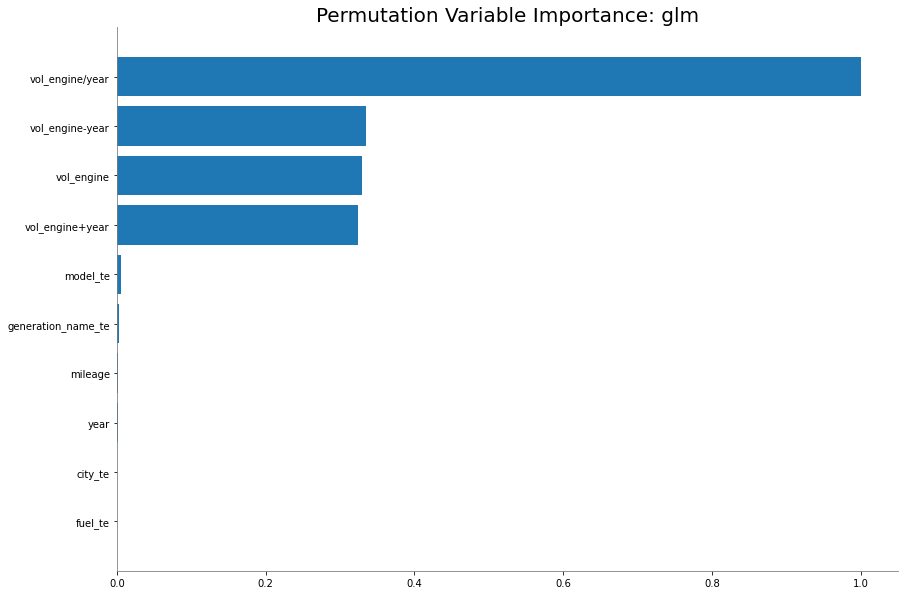


Variable Importances: 


,Variable,Relative Importance,Scaled Importance,Percentage
0,vol_engine/year,4.856949e+06,1.000000,0.500458
1,vol_engine-year,1.623661e+06,0.334297,0.167301
2,vol_engine,1.598644e+06,0.329146,0.164723
3,vol_engine+year,1.571998e+06,0.323660,0.161978
4,model_te,2.574717e+04,0.005301,0.002653
5,generation_name_te,1.167443e+04,0.002404,0.001203
6,mileage,8.488049e+03,0.001748,0.000875
7,year,4.704297e+03,0.000969,0.000485
8,city_te,1.305918e+03,0.000269,0.000135
9,fuel_te,9.725421e+02,0.000200,0.000100


In [74]:
import shap 

# calculate importance
permutation_varimp = bestmodel_glm_carPrices.permutation_importance(carPrices_test_te, use_pandas=True)

# plot permutation importance (bar plot)
bestmodel_glm_carPrices.permutation_importance_plot(carPrices_test_te)


Using feature permutation importance for GLM:
- The most important feature is `vol_engine/year`
- That is followed by `vol_engine-year`, and `vol_engine` and so on

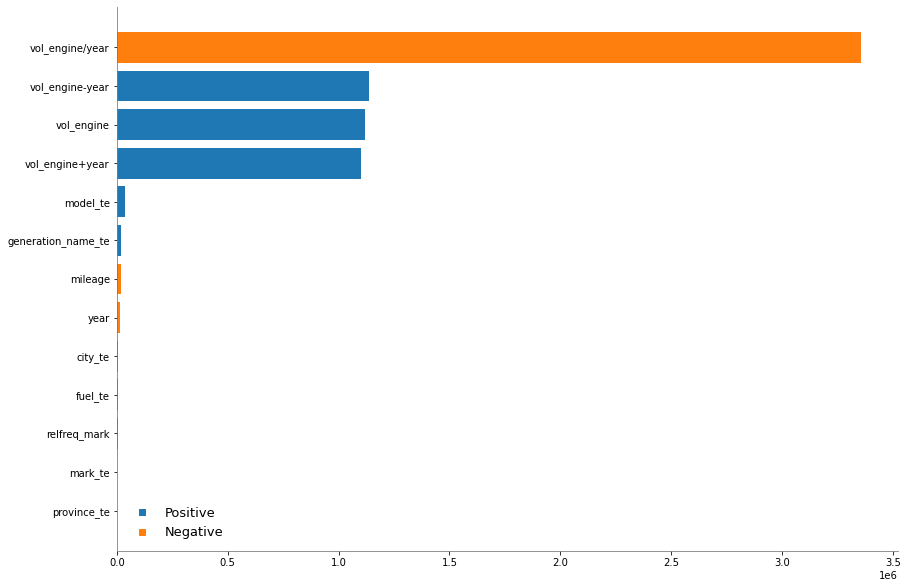

In [75]:
try:
    bestmodel_glm_carPrices.std_coef_plot()
except:
    pass

From the above graph we can conclude that:
- The vol_engine/year has a negative correlation with prices.
- The mileage also has a negative correlation with price. The higher the mileage, the lower is the price.
- All other features have a positive correlation with price.
- The importance of the features is from top to bottom.

## Boosted Model

### GBM

- For GBM model we need not use target encoding for the categorical variables. 
- First running a default model for GBM

In [35]:
from h2o.estimators import H2OGradientBoostingEstimator
predictors_gbm = carPrices_train.columns
predictors_gbm.remove(response)

In [36]:
gbm_model = H2OGradientBoostingEstimator(nfolds=0,
                                         seed=1234,
                                         ntrees=500,
                                         stopping_rounds=5,
                                         keep_cross_validation_predictions = False)

gbm_model.train(x=predictors_gbm, y=response, training_frame=carPrices_train, validation_frame=carPrices_valid)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1651951488463_4


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,423.0,423.0,365987.0,0.0,5.0,4.98818,1.0,32.0,24.67376




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 176754943.2155751
RMSE: 13294.921707764024
MAE: 6635.826719426127
RMSLE: 0.16696190113429885
Mean Residual Deviance: 176754943.2155751

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 399293658.6854474
RMSE: 19982.33366465107
MAE: 8376.252733826726
RMSLE: NaN
Mean Residual Deviance: 399293658.6854474

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2022-05-07 12:25:34,0.047 sec,0.0,84978.621435,54191.515882,7.221366e+09,85350.219341,54177.267548,7.284660e+09
1,,2022-05-07 12:25:34,0.548 sec,1.0,77518.952804,49258.320287,6.009188e+09,77994.803703,49277.561604,6.083189e+09
2,,2022-05-07 12:25:34,0.848 sec,2.0,70798.933179,44749.676034,5.012489e+09,71281.437779,44757.699316,5.081043e+09
3,,2022-05-07 12:25:35,1.160 sec,3.0,64879.361767,40775.455961,4.209332e+09,65448.703842,40805.040221,4.283533e+09
4,,2022-05-07 12:25:35,1.342 sec,4.0,59538.548095,37180.558290,3.544839e+09,60157.047623,37224.166296,3.618870e+09
5,,2022-05-07 12:25:35,1.513 sec,5.0,54759.521330,33904.789760,2.998605e+09,55477.470701,33983.869070,3.077750e+09
6,,2022-05-07 12:25:35,1.688 sec,6.0,50479.881609,30994.969571,2.548218e+09,51314.745194,31115.982368,2.633203e+09
7,,2022-05-07 12:25:35,1.804 sec,7.0,46634.610324,28382.801392,2.174787e+09,47613.335490,28535.527258,2.267030e+09
8,,2022-05-07 12:25:36,1.980 sec,8.0,43311.940219,26092.297997,1.875924e+09,44334.915711,26250.415229,1.965585e+09
9,,2022-05-07 12:25:36,2.121 sec,9.0,40340.833035,24040.792408,1.627383e+09,41425.160741,24197.912838,1.716044e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,model,1.176791e+15,1.000000,0.426966
1,year,1.160400e+15,0.986071,0.421019
2,generation_name,1.999632e+14,0.169923,0.072551
3,mileage,7.752287e+13,0.065877,0.028127
4,vol_engine+year,3.759579e+13,0.031948,0.013641
5,vol_engine,3.155368e+13,0.026813,0.011448
6,vol_engine-year,2.102312e+13,0.017865,0.007628
7,province,1.913159e+13,0.016257,0.006941
8,vol_engine/year,1.785097e+13,0.015169,0.006477
9,city,7.191215e+12,0.006111,0.002609


**Testing the performance of my GBM (not tuned yet) model on the testing dataset**

In [37]:
gbm_model.model_performance(carPrices_test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 340411971.15548366
RMSE: 18450.256669094975
MAE: 8309.019868436602
RMSLE: NaN
Mean Residual Deviance: 340411971.15548366


## Model Tuning for GBM

- Performing model tuning for my GBM model here
- Not performing the cross validation here (nfolds=0) and instead using the validation_frame parameter
- In my grid search, I am tuning the following parameters using Cartesian search criteria (default) - ntrees, learn_rate, max_depth, sample_rate, col_sample_rate


In [38]:
from h2o.grid.grid_search import H2OGridSearch

gbm_model_tune = H2OGradientBoostingEstimator(nfolds=0,
                                             stopping_rounds=5,
                                             keep_cross_validation_predictions = False,
                                             seed=1234)


gbm_params1 = { 
                'ntrees':[50,250,500],
                'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5,0.8, 1.0]
              }



#Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(
                          model=gbm_model_tune,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1
                          )


In [39]:
gbm_grid1.train(x=predictors_gbm, y=response,
                training_frame=carPrices_train,
                validation_frame=carPrices_valid
                )

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
        col_sample_rate  learn_rate  max_depth  ntrees  sample_rate  \
0                   0.5        0.01        9.0   500.0          1.0   
1                   0.5        0.01        9.0   500.0          0.8   
2                   0.5        0.10        9.0   500.0          1.0   
3                   0.5        0.10        9.0   250.0          1.0   
4                   0.5        0.10        9.0    50.0          1.0   
..  ..              ...         ...        ...     ...          ...   
103                 1.0        0.01        3.0    50.0          1.0   
104                 0.8        0.01        3.0    50.0          1.0   
105                 0.8        0.01        3.0    50.0          0.8   
106                 0.5        0.01        3.0    50.0          1.0   
107                 0.5        0.01        3.0    50.0          0.8   

               model_ids  residual_deviance  
0    g

**Sorting the results of my grid search (GBM) in ascending order based on RMSE to get the model with lowest RMSE**

In [40]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='RMSE', decreasing=False)
gbm_gridperf1

        col_sample_rate  learn_rate  max_depth  ntrees  sample_rate  \
0                   0.5        0.01        9.0   500.0          1.0   
1                   0.5        0.01        9.0   500.0          0.8   
2                   0.5        0.10        9.0   500.0          1.0   
3                   0.5        0.10        9.0   250.0          1.0   
4                   0.5        0.10        9.0    50.0          1.0   
..  ..              ...         ...        ...     ...          ...   
103                 1.0        0.01        3.0    50.0          1.0   
104                 0.8        0.01        3.0    50.0          1.0   
105                 0.8        0.01        3.0    50.0          0.8   
106                 0.5        0.01        3.0    50.0          1.0   
107                 0.5        0.01        3.0    50.0          0.8   

               model_ids          rmse  
0    gbm_grid1_model_103  19170.251579  
1     gbm_grid1_model_49  19257.860424  
2    gbm_grid1_model_106

In [41]:
best_gbm1 = gbm_gridperf1.models[0]
best_gbm1

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_grid1_model_103


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,500.0,500.0,4350341.0,9.0,9.0,9.0,85.0,433.0,306.08




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 187678091.58044106
RMSE: 13699.5653792535
MAE: 6499.575945232811
RMSLE: 0.1697058381301403
Mean Residual Deviance: 187678091.58044106

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 367498545.59335536
RMSE: 19170.251578770567
MAE: 8123.906672110962
RMSLE: 0.191001478559081
Mean Residual Deviance: 367498545.59335536

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2022-05-07 12:36:20,10 min 18.062 sec,0.0,84978.621435,54191.515882,7.221366e+09,85350.219341,54177.267548,7.284660e+09
1,,2022-05-07 12:36:20,10 min 18.119 sec,1.0,84184.474039,53669.717329,7.087026e+09,84570.952879,53660.408027,7.152246e+09
2,,2022-05-07 12:36:20,10 min 18.165 sec,2.0,83401.193543,53156.258459,6.955759e+09,83798.068653,53148.436628,7.022116e+09
3,,2022-05-07 12:36:20,10 min 18.234 sec,3.0,82619.884091,52646.146467,6.826045e+09,83032.391636,52641.621481,6.894378e+09
4,,2022-05-07 12:36:20,10 min 18.281 sec,4.0,81852.711351,52143.063502,6.699866e+09,82276.507061,52141.874966,6.769424e+09
5,,2022-05-07 12:36:20,10 min 18.349 sec,5.0,81092.327392,51643.838892,6.575966e+09,81529.280023,51644.973127,6.647024e+09
6,,2022-05-07 12:36:20,10 min 18.404 sec,6.0,80338.232170,51150.612433,6.454232e+09,80786.731145,51154.383997,6.526496e+09
7,,2022-05-07 12:36:20,10 min 18.450 sec,7.0,79589.870272,50659.189108,6.334547e+09,80050.136847,50665.503687,6.408024e+09
8,,2022-05-07 12:36:20,10 min 18.504 sec,8.0,78853.937408,50174.194158,6.217943e+09,79323.489201,50182.283282,6.292216e+09
9,,2022-05-07 12:36:20,10 min 18.575 sec,9.0,78127.098585,49695.275009,6.103844e+09,78606.136129,49706.430010,6.178925e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,model,7.554777e+15,1.000000,0.287554
1,year,7.487782e+15,0.991132,0.285004
2,mileage,3.343281e+15,0.442539,0.127254
3,generation_name,3.025125e+15,0.400425,0.115144
4,vol_engine/year,1.087399e+15,0.143935,0.041389
5,vol_engine+year,9.961548e+14,0.131858,0.037916
6,vol_engine,8.696329e+14,0.115110,0.033100
7,vol_engine-year,7.583691e+14,0.100383,0.028865
8,mark,6.824442e+14,0.090333,0.025976
9,province,2.624009e+14,0.034733,0.009988


**The parameters selected by the grid search for the best model are:** 

In [42]:
print("The best set of parameters for the GBM function:")
print("Best value for ntrees", best_gbm1.actual_params['ntrees'])
print("Best value for learn rate", best_gbm1.actual_params['learn_rate'])
print("Best value for max_depth", best_gbm1.actual_params['max_depth'])
print("Best value for sample_rate", best_gbm1.actual_params['sample_rate'])
print("Best value for col_sample_rate", best_gbm1.actual_params['col_sample_rate'])

The best set of parameters for the GBM function:
Best value for ntrees 500
Best value for learn rate 0.01
Best value for max_depth 9
Best value for sample_rate 1.0
Best value for col_sample_rate 0.5


### Final Best Tuned GBM model

- Created and trained the model with best parameters obtained from the grid search results.
- The grid results were sorted based on RMSE
- The best parameters obtained from running the grid search is:
- ntrees = 500
- learn_rate = 0.01
- max_depth = 9
- sample_rate = 1.0
- col_sample_rate = 0.5
- Created this model just for reference because the grid results take time to reproduce the same results

In [43]:
gbm_model_tuned_carPrices = H2OGradientBoostingEstimator(nfolds=0,
                                                         stopping_rounds=5,
                                                         keep_cross_validation_predictions = False,
                                                         ntrees = 500,
                                                         learn_rate = 0.01,
                                                         max_depth = 9,
                                                         sample_rate = 1,
                                                         col_sample_rate = 0.5,
                                                         seed=1234)

gbm_model_tuned_carPrices.train(x=predictors_gbm, y=response,
                                training_frame=carPrices_train,
                                validation_frame=carPrices_valid
                                )

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1651951488463_5


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,500.0,500.0,4350352.0,9.0,9.0,9.0,85.0,433.0,306.08




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 187678091.58044106
RMSE: 13699.5653792535
MAE: 6499.575945232811
RMSLE: 0.1697058381301403
Mean Residual Deviance: 187678091.58044106

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 367498545.59335536
RMSE: 19170.251578770567
MAE: 8123.906672110962
RMSLE: 0.191001478559081
Mean Residual Deviance: 367498545.59335536

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2022-05-07 12:42:03,0.002 sec,0.0,84978.621435,54191.515882,7.221366e+09,85350.219341,54177.267548,7.284660e+09
1,,2022-05-07 12:42:03,0.078 sec,1.0,84184.474039,53669.717329,7.087026e+09,84570.952879,53660.408027,7.152246e+09
2,,2022-05-07 12:42:03,0.144 sec,2.0,83401.193543,53156.258459,6.955759e+09,83798.068653,53148.436628,7.022116e+09
3,,2022-05-07 12:42:03,0.197 sec,3.0,82619.884091,52646.146467,6.826045e+09,83032.391636,52641.621481,6.894378e+09
4,,2022-05-07 12:42:03,0.244 sec,4.0,81852.711351,52143.063502,6.699866e+09,82276.507061,52141.874966,6.769424e+09
5,,2022-05-07 12:42:03,0.301 sec,5.0,81092.327392,51643.838892,6.575966e+09,81529.280023,51644.973127,6.647024e+09
6,,2022-05-07 12:42:03,0.354 sec,6.0,80338.232170,51150.612433,6.454232e+09,80786.731145,51154.383997,6.526496e+09
7,,2022-05-07 12:42:03,0.401 sec,7.0,79589.870272,50659.189108,6.334547e+09,80050.136847,50665.503687,6.408024e+09
8,,2022-05-07 12:42:03,0.455 sec,8.0,78853.937408,50174.194158,6.217943e+09,79323.489201,50182.283282,6.292216e+09
9,,2022-05-07 12:42:03,0.517 sec,9.0,78127.098585,49695.275009,6.103844e+09,78606.136129,49706.430010,6.178925e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,model,7.554777e+15,1.000000,0.287554
1,year,7.487782e+15,0.991132,0.285004
2,mileage,3.343281e+15,0.442539,0.127254
3,generation_name,3.025125e+15,0.400425,0.115144
4,vol_engine/year,1.087399e+15,0.143935,0.041389
5,vol_engine+year,9.961548e+14,0.131858,0.037916
6,vol_engine,8.696329e+14,0.115110,0.033100
7,vol_engine-year,7.583691e+14,0.100383,0.028865
8,mark,6.824442e+14,0.090333,0.025976
9,province,2.624009e+14,0.034733,0.009988


**Testing the performance of my best tuned GBM model on the testing dataset**

In [44]:
gbm_model_tuned_carPrices.model_performance(carPrices_test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 351054751.3627176
RMSE: 18736.455143989155
MAE: 8083.967923818896
RMSLE: 0.19697371617494294
Mean Residual Deviance: 351054751.3627176


### Saving my best model for GBM

- Selecting my best tuned GBM model with above parameters
- Saving the model to be used in my scoring function
- Reason for selecting the GBM model is a lower RMSE and MAE out of all the models

In [45]:
# # save the model
# model_path = h2o.save_model(model=best_gbm1, path="/Users/General/Documents/UTD/Semester 3/Applied Machine Learning/Projects/Project 2/CarPrices/artifacts_CarPrices", force=True)
# print(model_path)

C:\Users\General\Documents\UTD\Semester 3\Applied Machine Learning\Projects\Project 2\CarPrices\artifacts_CarPrices\gbm_grid1_model_103


In [46]:
# upload the model that you just downloded above
# to the H2O cluster
model_path = "./artifacts_CarPrices/gbm_grid1_model_103"

In [47]:
best_gbm_carPrices = h2o.upload_model(model_path)

In [48]:
best_gbm_carPrices

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_grid1_model_103


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,500.0,500.0,4350341.0,9.0,9.0,9.0,85.0,433.0,306.08




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 187678091.58044106
RMSE: 13699.5653792535
MAE: 6499.575945232811
RMSLE: 0.1697058381301403
Mean Residual Deviance: 187678091.58044106

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 367498545.59335536
RMSE: 19170.251578770567
MAE: 8123.906672110962
RMSLE: 0.191001478559081
Mean Residual Deviance: 367498545.59335536

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2022-05-07 12:36:20,10 min 18.062 sec,0.0,84978.621435,54191.515882,7.221366e+09,85350.219341,54177.267548,7.284660e+09
1,,2022-05-07 12:36:20,10 min 18.119 sec,1.0,84184.474039,53669.717329,7.087026e+09,84570.952879,53660.408027,7.152246e+09
2,,2022-05-07 12:36:20,10 min 18.165 sec,2.0,83401.193543,53156.258459,6.955759e+09,83798.068653,53148.436628,7.022116e+09
3,,2022-05-07 12:36:20,10 min 18.234 sec,3.0,82619.884091,52646.146467,6.826045e+09,83032.391636,52641.621481,6.894378e+09
4,,2022-05-07 12:36:20,10 min 18.281 sec,4.0,81852.711351,52143.063502,6.699866e+09,82276.507061,52141.874966,6.769424e+09
5,,2022-05-07 12:36:20,10 min 18.349 sec,5.0,81092.327392,51643.838892,6.575966e+09,81529.280023,51644.973127,6.647024e+09
6,,2022-05-07 12:36:20,10 min 18.404 sec,6.0,80338.232170,51150.612433,6.454232e+09,80786.731145,51154.383997,6.526496e+09
7,,2022-05-07 12:36:20,10 min 18.450 sec,7.0,79589.870272,50659.189108,6.334547e+09,80050.136847,50665.503687,6.408024e+09
8,,2022-05-07 12:36:20,10 min 18.504 sec,8.0,78853.937408,50174.194158,6.217943e+09,79323.489201,50182.283282,6.292216e+09
9,,2022-05-07 12:36:20,10 min 18.575 sec,9.0,78127.098585,49695.275009,6.103844e+09,78606.136129,49706.430010,6.178925e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,model,7.554777e+15,1.000000,0.287554
1,year,7.487782e+15,0.991132,0.285004
2,mileage,3.343281e+15,0.442539,0.127254
3,generation_name,3.025125e+15,0.400425,0.115144
4,vol_engine/year,1.087399e+15,0.143935,0.041389
5,vol_engine+year,9.961548e+14,0.131858,0.037916
6,vol_engine,8.696329e+14,0.115110,0.033100
7,vol_engine-year,7.583691e+14,0.100383,0.028865
8,mark,6.824442e+14,0.090333,0.025976
9,province,2.624009e+14,0.034733,0.009988


**A function to evaluate the performance of the model**

In [49]:
def evaluate(eval_carPrices):
    print("RMSE:", eval_carPrices.rmse())    
    print("MAE:", eval_carPrices.mae())
    print("MSE:", eval_carPrices.mse())
    print("R-square:",  eval_carPrices.r2())
    print("RMSLE:",  eval_carPrices.rmsle())

In [50]:
eval_carPrices_train = best_gbm_carPrices.model_performance(carPrices_train)
eval_carPrices_test = best_gbm_carPrices.model_performance(carPrices_test)

**Final metrics of the best tuned GBM model using training dataset**

In [51]:
print("Performance matrix for train dataset")
evaluate(eval_carPrices_train)

Performance matrix for train dataset
RMSE: 13699.566376666262
MAE: 6499.57611666201
MSE: 187678118.90868476
R-square: 0.9740107181541379
RMSLE: 0.16970585514386222


**Final metrics of the best tuned GBM model using testing dataset**

In [52]:
print("Performance matrix for test dataset")
evaluate(eval_carPrices_test)

Performance matrix for test dataset
RMSE: 18736.455143989155
MAE: 8083.967923818896
MSE: 351054751.3627176
R-square: 0.9501562488482777
RMSLE: 0.19697371617494294


## Interpreting Final Trained GBM Model

In [53]:
import shap

**Global feature importance using Shapley values**

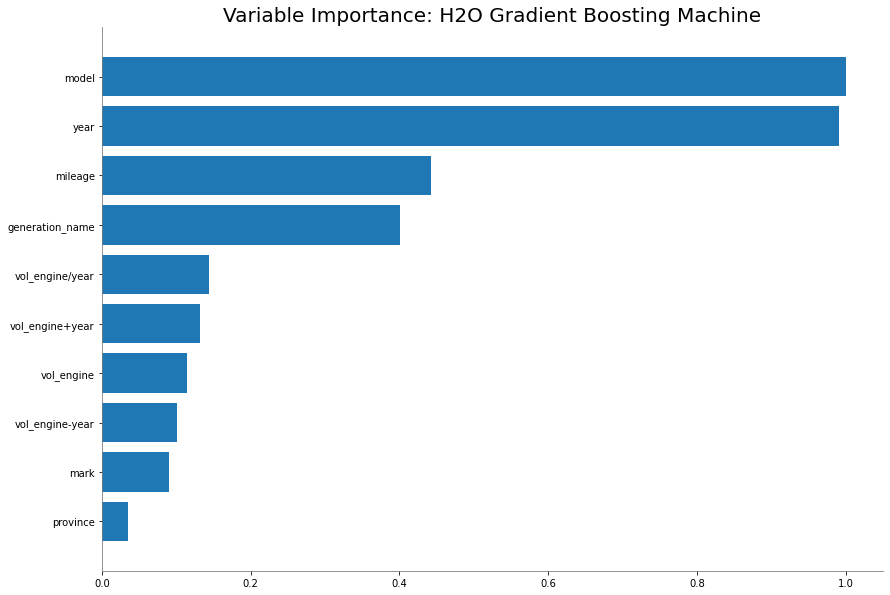

<Figure size 432x288 with 0 Axes>

In [54]:
best_gbm_carPrices.varimp_plot()

Using Global level interpretation of GBM model using shapley values:
- The most important feature is `model`
- It is followed by `year` and `mileage` and so on

**Calculating and Plotting permutation feature importance**

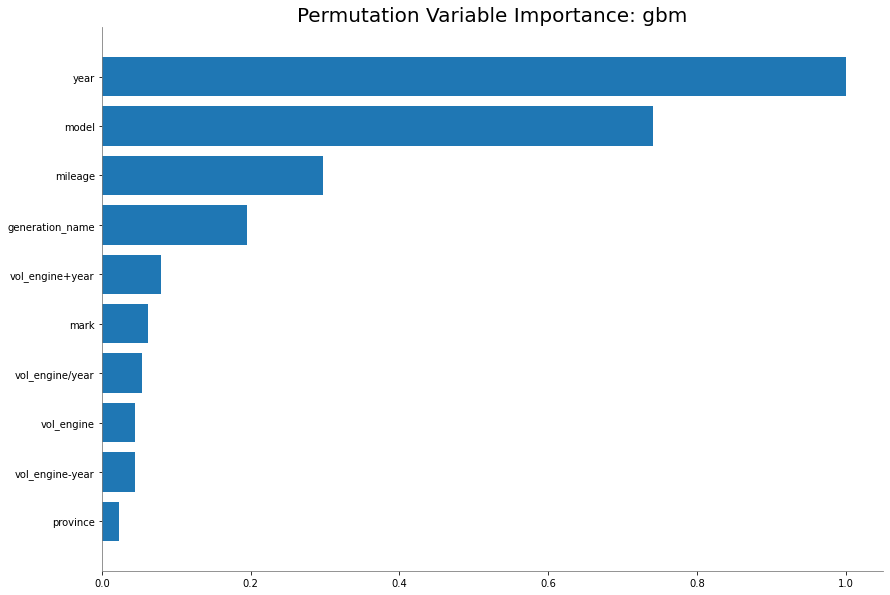


Variable Importances: 


,Variable,Relative Importance,Scaled Importance,Percentage
0,year,41824.204529,1.000000,0.389517
1,model,30973.056194,0.740553,0.288458
2,mileage,12454.573807,0.297784,0.115992
3,generation_name,8153.834556,0.194955,0.075938
4,vol_engine+year,3338.470267,0.079821,0.031092
5,mark,2581.644268,0.061726,0.024043
6,vol_engine/year,2273.124879,0.054350,0.021170
7,vol_engine,1868.749683,0.044681,0.017404
8,vol_engine-year,1860.345324,0.044480,0.017326
9,province,945.159300,0.022598,0.008802


In [55]:
# calculate importance
permutation_varimp = best_gbm_carPrices.permutation_importance(carPrices_test, use_pandas=True)

# plot permutation importance (bar plot)
best_gbm_carPrices.permutation_importance_plot(carPrices_test)


Using feature permutation importance for GBM model:
- The most important feature is `year`
- That is followed by `model` and `mileage` and so on

**Summary plot with Shapley values**

In [56]:
# The function is to calculate Shapley values (contributions) and plot them for multiple records
def examine_all_reason_codes(data, model):
    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols
                            )

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


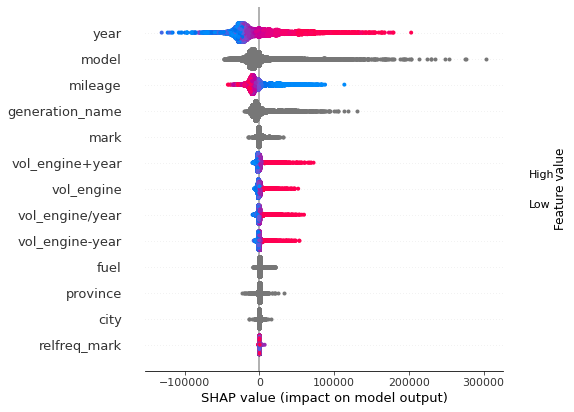

In [57]:
examine_all_reason_codes(carPrices_test, best_gbm_carPrices)

The above summary plot shows that:
- The most important feature is `year`. It looks like it has a positive correlation with SHAP values. The higher the value of `year` feature, the higher is the SHAP value(impact on model output). Meaning the cars manufactured in the recent years will have higher prices.
- The second important deature is `model`.
- The next is the `mileage` having negative correlation with SHAP values. The higher the mileage, the lower is the price.

## Individual observations analysis using Shapley values

In [58]:
predict_price = best_gbm_carPrices.predict(carPrices_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [59]:
carPrices_test["pricehat"] = predict_price
carPrices_test["abs_error"] = abs(carPrices_test["price"] - carPrices_test["pricehat"])

In [60]:
pred_contributions_orig_table = best_gbm_carPrices.predict_contributions(carPrices_test)
contrib_columns = []

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [61]:
for col in carPrices_test.columns:
    if col not in ['BiasTerm','price','pricehat','abs_error']:
        contrib_columns.append("contrib_"+col)

contrib_columns.append('BiasTerm')

In [62]:
pred_contributions_orig_table.columns = contrib_columns
carPrices_test_yhat = carPrices_test

In [63]:
carPrices_test_yhat = carPrices_test_yhat.cbind(pred_contributions_orig_table)
include_columns = carPrices_test.columns
include_columns.remove("pricehat")
include_columns.remove("abs_error")
include_columns.remove("price")

**Need to Sort the dataframe by abs_error**

In [64]:
carPrices_test_yhat = carPrices_test_yhat.as_data_frame()
carPrices_test_yhat = carPrices_test_yhat.sort_values(by='abs_error', ascending=True).reset_index(drop=True)

In [65]:
shap.initjs()
def examine_indiv_reason_codes(df_vals_and_cotribs,
                               rec_num, 
                               include_columns, 
                               contrib_columns,
                               use_matplotlib=True):
    
    shap_columns = contrib_columns.copy()
    shap_columns.remove("BiasTerm")
    ftr_columns = include_columns.copy()
    #ftr_columns.remove("DEFAULT_NEXT_MONTH")
    bias = df_vals_and_cotribs['BiasTerm'].iloc[rec_num]
    shap_contribs = df_vals_and_cotribs[shap_columns].iloc[rec_num,:].values
    ftr_values =    df_vals_and_cotribs[ftr_columns].iloc[rec_num,:].values
    
    return shap.force_plot(bias, 
                           shap_contribs, 
                           ftr_values, 
                           shap_columns,
                           matplotlib=use_matplotlib)

**Top 3 records (smallest residuals)**

In [66]:
carPrices_test_yhat.head(3)

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,vol_engine-year,vol_engine+year,vol_engine/year,relfreq_mark,pricehat,abs_error,contrib_mark,contrib_model,contrib_generation_name,contrib_year,contrib_mileage,contrib_vol_engine,contrib_fuel,contrib_city,contrib_province,contrib_vol_engine-year,contrib_vol_engine+year,contrib_vol_engine/year,contrib_relfreq_mark,BiasTerm
0,kia,ceed,gen-i-2006-2012,2009,116410,1396,Gasoline,Jasieniec,Mazowieckie,19999,-613,3405,0.694873,146.521739,19999.316855,0.316855,-1224.015381,-10735.812500,-9529.391602,-21822.177734,-2677.199951,-1085.059814,102.448250,-57.528282,360.473663,-981.470215,-1702.485718,-987.802979,-4.769841,70344.09375
1,volkswagen,touran,gen-i-2003-2010,2005,197000,1598,Gasoline,ToruÅ„,Kujawsko-pomorskie,15400,-407,3603,0.797007,424.173913,15400.584495,0.584495,-536.089966,-3707.657471,-8027.354004,-29165.890625,-9655.846680,-802.578064,19.237831,-58.709530,-364.969208,-704.443176,-1240.792480,-706.859985,8.443932,70344.09375
2,mercedes-benz,e-klasa,gen-w211-2002-2009,2008,380000,2148,Diesel,Warszawa,Mazowieckie,22000,140,4156,1.069721,281.217391,22000.835911,0.835911,3136.430664,11300.350586,-6413.660156,-35788.871094,-20456.822266,150.288193,-594.220764,-47.078297,223.666199,-27.828213,205.232910,-70.271378,39.787296,70344.09375


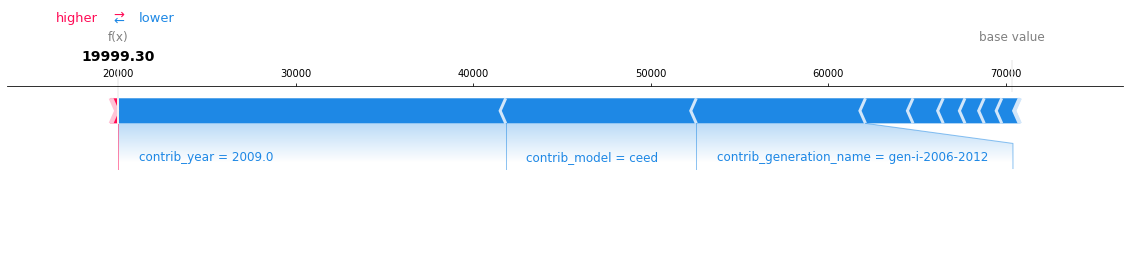

In [67]:
examine_indiv_reason_codes(carPrices_test_yhat,0,include_columns,contrib_columns)

The predicted car price is $19,999.30 with lowest error. The prediction is mostly influenced by contributions from `year` = 2009 and `model` = ceed which are responsible to pull down the price from base value

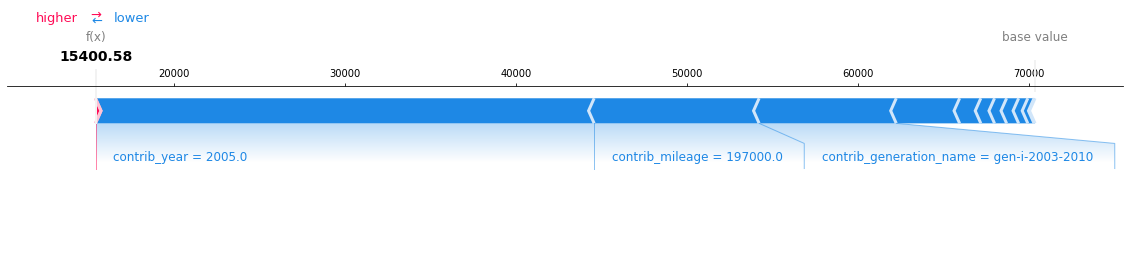

In [68]:
examine_indiv_reason_codes(carPrices_test_yhat,1,include_columns,contrib_columns)

The predicted car price is $15,400.58 with second lowest error. The prediction is mostly influenced by contributions from `year` = 2005, responsible to down the price and `mileage` = 197,000 which is responsible to pull down the price from base value.

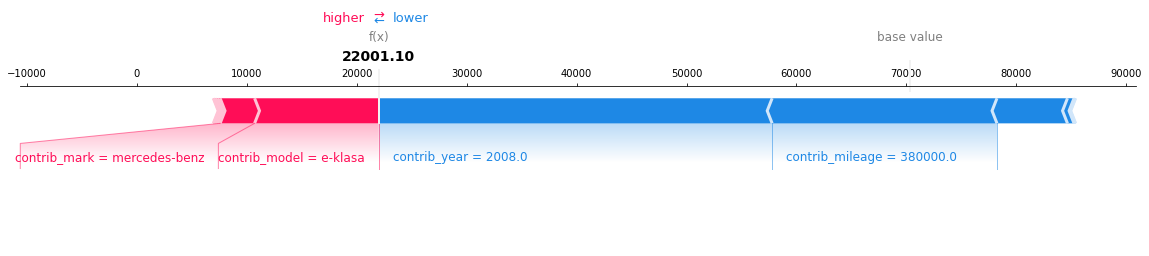

In [69]:
examine_indiv_reason_codes(carPrices_test_yhat,2,include_columns,contrib_columns)

The predicted car price is $22,001.10 with third lowest error. The prediction is mostly influenced by contributions from `year` = 2008, responsible to pull down the price and `mileage` = 380000 which is responsible to pull down the price from base value. `model` = e-klasa is responsible for pulling up the price of the car.

**Bottom 3 records (largest residuals)**

In [70]:
carPrices_test_yhat.tail(3)

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,vol_engine-year,vol_engine+year,vol_engine/year,relfreq_mark,pricehat,abs_error,contrib_mark,contrib_model,contrib_generation_name,contrib_year,contrib_mileage,contrib_vol_engine,contrib_fuel,contrib_city,contrib_province,contrib_vol_engine-year,contrib_vol_engine+year,contrib_vol_engine/year,contrib_relfreq_mark,BiasTerm
15809,mercedes-benz,g-klasa,gen-w463-1992,2012,34476,5461,Gasoline,PruszkÃ³w,Mazowieckie,984000,3449,7473,2.714215,281.217391,512499.235745,471500.764255,10958.866211,139181.171875,130810.531250,-48788.625000,46924.542969,33646.824219,-295.775360,526.022400,12602.797852,30401.728516,54204.941406,31044.058594,933.682739,70344.09375
15810,mercedes-benz,s-klasa,gen-w223-2020,2021,9000,2999,Gasoline,Sosnowiec,ÅšlÄ…skie,73800,978,5020,1.483919,281.217391,676481.076111,602681.076111,17273.835938,171912.796875,38401.781250,163816.968750,83330.382812,26416.851562,530.513489,-5146.268066,1985.651245,26685.421875,41402.644531,37769.722656,1744.131226,70344.09375
15811,bmw,m8,NaN,2021,0,0,Gasoline,WrocÅ‚aw,DolnoÅ›lÄ…skie,969900,-2021,2021,0.000000,432.565217,318238.746787,651661.253213,14571.995117,96731.085938,-2489.058105,105915.070312,58787.097656,-5647.600098,438.214996,-546.777893,2757.833984,-6677.814453,-9316.252930,-6968.733887,339.219940,70344.09375


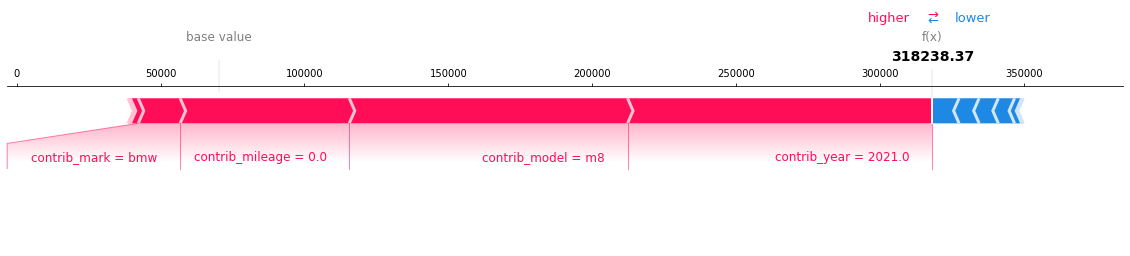

In [71]:
examine_indiv_reason_codes(carPrices_test_yhat,15811,include_columns,contrib_columns)

The predicted car price is $318238.37 with maximum error. The prediction is mostly influenced by contributions from `year` = 2010, responsible to pull up the price and `model` = m8 which is responsible to pull up the price from base value.

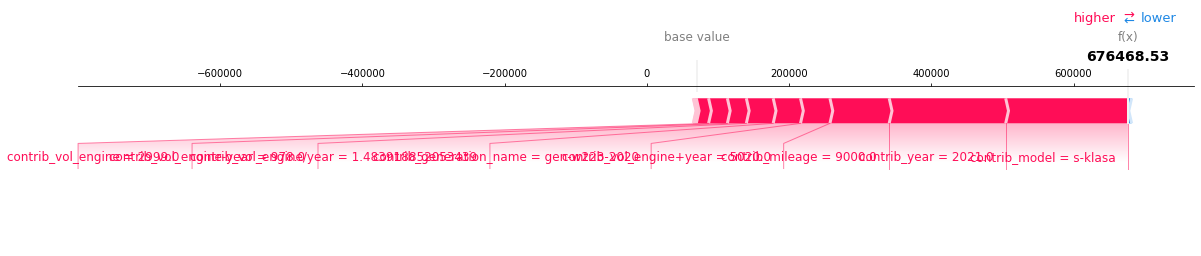

In [72]:
examine_indiv_reason_codes(carPrices_test_yhat,15810,include_columns,contrib_columns)

The predicted car price is $676,468.53 with second maximum error. The prediction is mostly influenced by contributions from `model` = s-klasa, responsible to pull up the price and `year` = 2021 which is responsible to pull up the price from base value.

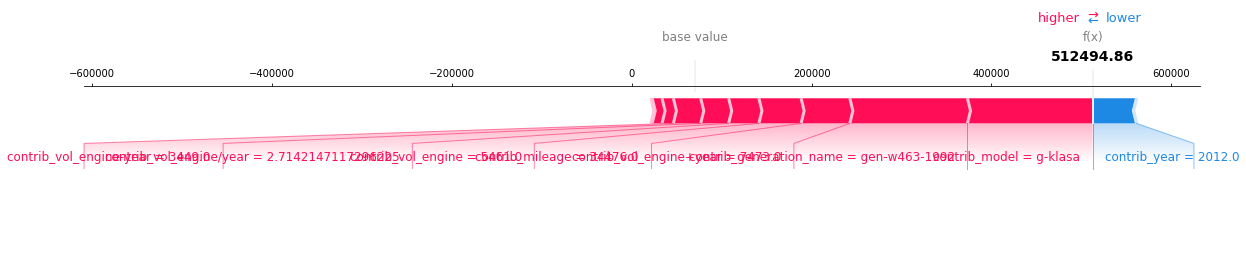

In [73]:
examine_indiv_reason_codes(carPrices_test_yhat,15809,include_columns,contrib_columns)

The predicted car price is $512,494.86 with third maximum error. The prediction is mostly influenced by contributions from `model` = g-klasa, responsible to pull up the price and `generation_name` = gen-w463-1000 which is responsible to pull up the price from base value.